# COMP47590 Advanced Machine Learning
# Pefroming a Machine Learning Benchmarking Experiment in Python

## Imports

Import the libraries we will use - **aeon** is the new one we use for nice benchmarking imlpementations. 

In [1]:
# If using Google Colab uncomment this line to add the aeon package.
#!pip install aeon

In [2]:
import io
import random 
import time
import pickle

import pandas as pd # core data handling package
import numpy as np # core data handling package
import matplotlib # core plotting functioanlity
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # nicer plotting functionlity

import sklearn # For basic machine learning functionality
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble

# import aeon # time series classification package with nice benchmarking functions
# import aeon.benchmarking
# import aeon.benchmarking.stats
# import aeon.visualisation

## Google Colab

If using Google Colab comment out code in these cells to mount your Google drive for data access.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Uncomment this code and change the path to match where you have stored course data

In [4]:
#%cd /content/drive/MyDrive/Teaching/UCD Advanced Machine Learning/2024-2025/Labs Public/

## Setup

Take only a sample of the dataset for fast testing

In [5]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [6]:
grid_search_cv_folds = 2

Setup the number of folds for all grid searches (should be 5 - 10)

In [7]:
final_cv_folds = 2

Set up a dictionary to store simple model performance comparions

In [8]:
model_evaluation_results = dict()

### Setup Datasets

Set up a dictionary to store details of datasets to be used in the experiment

In [9]:
datasets = dict()

Load the dataset and explore it.

In [10]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1:"1", 2: "2", 3:"3", 4:"4", 5:"5", 6:"6", 7:"7", 8:"8", 9:"9"}
datasets["mnist"] = dataset_details

In [11]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/fashion-mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
datasets["mnist_fashion"] = dataset_details

In [12]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/kmnist.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1:"1", 2: "2", 3:"3", 4:"4", 5:"5", 6:"6", 7:"7", 8:"8", 9:"9"}
datasets["kmnist"] = dataset_details

### Setup Models

Setup a dictioanry of models and hyper-parramtee training details that will be evaluated. 

In [13]:
models = dict()

Decision Tree

In [14]:
model_details = dict()
model_details['base_model'] = sklearn.tree.DecisionTreeClassifier()
model_details['param_grid'] ={'criterion': ['gini', "entropy"], 
                              'max_depth': list(range(3, 50, 3)), 
                              'min_samples_split': [50]}
models['decision_tree'] = model_details

Bagging

In [15]:
model_details = dict()
model_details['base_model'] = sklearn.ensemble.BaggingClassifier(estimator = sklearn.tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200))
model_details['param_grid'] ={'n_estimators': list(range(50, 501, 50))}
models['bagging'] = model_details

Gradient Boosting

In [16]:
#model_details = dict()
#model_details['base_model'] = sklearn.ensemble.GradientBoostingClassifier(max_depth = 3)
#model_details['param_grid'] = {'n_estimators': list(range(50, 501, 100)),
#                               'learning_rate': [0.001, 0.01, 0.1]}
#models['gradient_boosting'] = model_details

Random Forest

In [17]:
model_details = dict()
model_details['base_model'] = sklearn.ensemble.RandomForestClassifier(min_samples_split=200)
model_details['param_grid'] = {'n_estimators': list(range(50, 501, 100)),
                               'max_features': list(range(2, 10, 2))}
models['random_forest'] = model_details

## Experiment Loop

Iterate through each dataset and then for each model. For exach combination perfomr a hyper-parameter tuning grid search and a final cross validation experiment.

In [15]:
data_model_evaluation_results = dict()

for dataset_name in datasets:

    print(dataset_name)

    dataset_details = datasets[dataset_name]
    
    file_name = dataset_details["file_name"]
    target_feature = dataset_details["target_feature"]
    num_classes = dataset_details["num_classes"]
    classes = dataset_details["classes"] 

    dataset = pd.read_csv(file_name)
    dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everything runs smoothly

    X = dataset.loc[:, dataset.columns != target_feature]
    y = dataset[target_feature]

    model_evaluation_results = dict()
    
    for model_name in models:

        print("\t{}".format(model_name))

        model_details = models[model_name]
        
        evaluation_results = dict()

        # Perform a grid search
        print('\t\tPerforming grid search')
        grid_search_results = sklearn.model_selection.GridSearchCV(model_details['base_model'], 
                                                                   model_details['param_grid'], 
                                                                   cv=grid_search_cv_folds, verbose = 1, 
                                                                   n_jobs = -1)
        grid_search_results.fit(X, y)
        print("\t\tBest Parameters: {}".format(grid_search_results.best_params_))
        
        # Store the grid search results
        evaluation_results['best_params'] = grid_search_results.best_params_
        evaluation_results['best_score'] = grid_search_results.best_score_
        evaluation_results['cv_results'] = grid_search_results.cv_results_

        # Perform final cross validation
        print('\t\tPerforming final cross validation')
        best_model = grid_search_results.best_estimator_ 
        cv_results = sklearn.model_selection.cross_validate(best_model, X, y, cv=final_cv_folds)
        print("\t\t{} +/- {}".format(cv_results['test_score'].mean(), cv_results['test_score'].std()))
        
        # Store the cross validation results
        evaluation_results['final_cv_results'] = cv_results
        evaluation_results['final_cv_mean'] = cv_results['test_score'].mean()
        evaluation_results['final_cv_std_dev'] = cv_results['test_score'].std()

        # Add all evaluation details to the evaluation dictionary
        model_evaluation_results[model_name] = evaluation_results

        with open('evaluation_results_' + time.strftime("%Y%m%d_%H%M%S") + '.data', 'wb') as f:
            pickle.dump(model_evaluation_results, f)

    data_model_evaluation_results[dataset_name] = model_evaluation_results

mnist
	decision_tree
		Performing grid search
Fitting 2 folds for each of 32 candidates, totalling 64 fits
		Best Parameters: {'criterion': 'entropy', 'max_depth': 45, 'min_samples_split': 50}
		Performing final cross validation
		0.7276666666666667 +/- 0.0026666666666666505
	bagging
		Performing grid search
Fitting 2 folds for each of 10 candidates, totalling 20 fits
		Best Parameters: {'n_estimators': 150}
		Performing final cross validation
		0.5880000000000001 +/- 0.02466666666666667
	random_forest
		Performing grid search
Fitting 2 folds for each of 20 candidates, totalling 40 fits
		Best Parameters: {'max_features': 8, 'n_estimators': 250}
		Performing final cross validation
		0.8341666666666667 +/- 0.004166666666666707
mnist_fashion
	decision_tree
		Performing grid search
Fitting 2 folds for each of 32 candidates, totalling 64 fits
		Best Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 50}
		Performing final cross validation
		0.7216666666666667 +/- 0.0013

## Comparing Models

Generate table of model perfomrances form the dictiaonry containing experiment results.

In [16]:
data = []
for row_key, sub_dict in data_model_evaluation_results.items():
    row_data = {"Index": row_key}
    for col_key, inner_dict in sub_dict.items():
        row_data[col_key] = inner_dict.get('final_cv_mean', None)  # Extract the specific value
    data.append(row_data)
results_df = pd.DataFrame(data).set_index("Index")
print(results_df)

               decision_tree   bagging  random_forest
Index                                                
mnist               0.727667  0.588000       0.834167
mnist_fashion       0.721667  0.630167       0.773333
kmnist              0.594833  0.384667       0.732667


Convert to ranks.

In [31]:
ranks_df = results_df.rank(method="min", ascending=False, axis = 1)
print(ranks_df)

               decision_tree  bagging  random_forest
Index                                               
mnist                    2.0      3.0            1.0
mnist_fashion            2.0      3.0            1.0
kmnist                   2.0      3.0            1.0


Perfrom a Friedman test to see if there is a difference in model performances.

In [32]:
aeon.benchmarking.stats.check_friedman(ranks_df.values)

0.04978706836786395

Perform a Nemenyi test to to see where the differences are.

In [34]:
avg_ranks = np.mean(ranks_df, axis=0)
print(avg_ranks)
aeon.benchmarking.stats.nemenyi_test(avg_ranks, len(avg_ranks), 0.05)

decision_tree    2.0
bagging          3.0
random_forest    1.0
dtype: float64


array([[ True,  True, False],
       [False,  True, False],
       [ True,  True,  True]])

Draw a critical differences plot to see where differences between model perfomrance exists. 

In [35]:
ranks_df.index

Index(['mnist', 'mnist_fashion', 'kmnist'], dtype='object', name='Index')

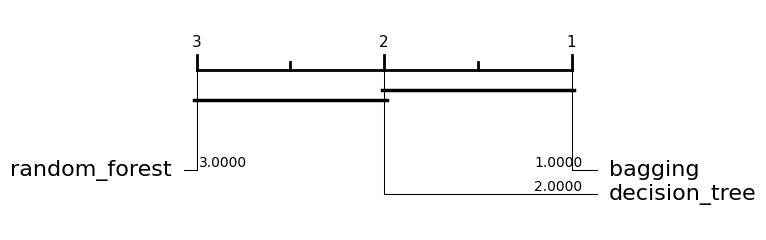

In [37]:
aeon.visualisation.plot_critical_difference(ranks_df.values, 
                                            ranks_df.columns, 
                                            test="Nemenyi")
plt.show()